In [101]:
from os import environ
from sqlalchemy import create_engine
import pandas as pd
import matplotlib.pyplot as plt
import math
import networkx as nx
import numpy as np

In [2]:
engine = create_engine()



In [12]:
user_df = pd.read_sql_table(
    "user",
    con=engine,
    schema='public',
    coerce_float=True,
    parse_dates=['created_at'],
)

chat_df = pd.read_sql_table(
    "chat_message",
    con=engine,
    schema='public',
    index_col = 'id',
    coerce_float=True,
    parse_dates=[
        'created_at',
        'updated_at'
    ],
)
group_df = pd.read_sql_table(
    "group",
    con=engine,
    schema='public',
    index_col = 'name',
    coerce_float=True,
    parse_dates=[
        'created_at',
        'updated_at'
    ],
)

workout_df = pd.read_sql_table(
    "workout",
    con=engine,
    schema='public',
    index_col = 'id',
    coerce_float=True,
    parse_dates=[
        'created_at',
        'updated_at'
    ],
)


user_exercise_df = pd.read_sql_table(
    "user_exercise",
    con=engine,
    schema='public',
    index_col = ['slug_name', 'username'],
    coerce_float=True,
    parse_dates=[
        'created_at',
        'updated_at'
    ],
)

battle_df = pd.read_sql_table(
    "battle",
    con=engine,
    schema='public',
    coerce_float=True,
    parse_dates=[
        'created_at',
        'updated_at'
    ],
)


session_analytics_df = pd.read_sql('select id, username, created_at, array_to_json(analytics) as path from "session_analytics"', con = engine)






In [13]:
from datetime import datetime, timedelta
created_at = session_analytics_df.iloc[0]['created_at']
sections = []

for row in session_analytics_df.iterrows():
    for section in row[1]['path']:
        sections.append([row[1]['id'], section['section'], created_at])
        created_at += timedelta(seconds=section['time_spent'])

In [188]:
section_to_ID = {"strengthModalVisible": 0,
                 "workoutModalVisible": 1,
                 "chatModalVisible": 2,
                 "UserTab": 3,
                 "MembersTab": 4, 
                 "EnemyTab": 5}
#[i][j] should denote the number of times i lead to j

In [258]:
section_before_after = np.zeros((7,7))
for row in session_analytics_df.iterrows():
    previous_section_id = None
    for section in row[1]['path']:
        try:
            current_id = section_to_ID[section['section']]
        except:
            continue
        if previous_section_id != None: 
            section_before_after[previous_section_id][current_id] += 1
        previous_section_id = current_id
for i in range(7):
   section_before_after[i][i] = 0
non_0 = section_before_after.nonzero()
tuples = []
for t in range(15):
    r = non_0[0][t]
    c = non_0[1][t]
    tuples.append((r, c, section_before_after[r][c]))

15

In [320]:
FG = nx.DiGraph()
FG.add_weighted_edges_from(tuples)
max_val = section_before_after.max()
arcs = nx.draw_networkx_edges(FG,  
                                pos=nx.circular_layout(FG),
                                connectionstyle=’arc3,rad=0.2’
                             )
for i, arc in enumerate(arcs):  # change alpha values of arcs
    print(tuples[i][2] / max_val)
    arc.set_alpha(tuples[i][2] / max_val) 
nx.draw_networkx_nodes(FG, pos=nx.circular_layout(FG))

SyntaxError: invalid character in identifier (<ipython-input-320-b71edabb87c8>, line 6)

In [133]:
user_with_counts = user_df
counts = user_with_counts.groupby('groupname').count().reset_index().rename(columns = {"created_at": "Number of members"})[['groupname', 'Number of members']]
user_with_counts = user_with_counts.merge(counts, on = "groupname", how = "left")
user_with_counts['Number of members'] = user_with_counts['Number of members'].apply(lambda x:  0 if math.isnan(x) else x)

counts = workout_df.groupby('username').count().reset_index().rename(columns = {"created_at": "Tracked workouts"})[['username', 'Tracked workouts']]
user_with_counts = user_with_counts.merge(counts, on = "username", how = "left")
user_with_counts['Tracked workouts'] = user_with_counts['Tracked workouts'].apply(lambda x:  0 if math.isnan(x) else x)

counts = user_exercise_df.groupby('username').count().reset_index().rename(columns = {"created_at": "Tracked personal bests"})[['username', 'Tracked personal bests']]
user_with_counts = user_with_counts.merge(counts, on = "username", how = "left")
user_with_counts['Tracked personal bests'] = user_with_counts['Tracked personal bests'].apply(lambda x:  0 if math.isnan(x) else x)

counts = chat_df.groupby('username').count().reset_index().rename(columns = {"created_at": "Chat messages"})[['username', 'Chat messages']]
user_with_counts = user_with_counts.merge(counts, on = "username", how = "left")
user_with_counts['Chat messages'] = user_with_counts['Chat messages'].apply(lambda x:  0 if math.isnan(x) else x)

counts = session_analytics_df.groupby('username').count().reset_index().rename(columns = {"created_at": "Number of app opens"})[['username', 'Number of app opens']]
user_with_counts = user_with_counts.merge(counts, on = "username", how = "left")
user_with_counts['Number of app opens'] = user_with_counts['Number of app opens'].apply(lambda x:  0 if math.isnan(x) else x)






Text(0, 0.5, 'Average per-user actions')

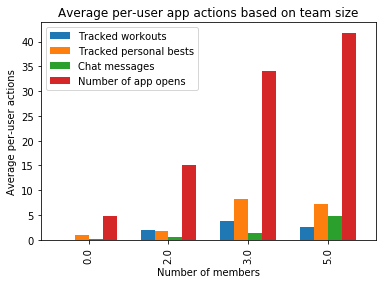

In [61]:
to_plot = user_with_counts.groupby('Number of members').mean()
ax = to_plot.plot.bar(width = 0.7, title = "Average per-user app actions based on team size")
ax.set_ylabel("Average per-user actions")

In [62]:
def get_end_date(row):
    next_battle = battle_df[battle_df['groupname'] == row['groupname']]
    next_battle = next_battle[battle_df['battle_number'] == row['battle_number'] + 1]
    if len(next_battle):
        row['ended_at'] = next_battle.iloc[0]['created_at']
    return row
with_end_times = battle_df.apply(get_end_date, axis = 1)
with_end_times = with_end_times[with_end_times['ended_at'].notnull()]
with_end_times = with_end_times.rename(columns = {"created_at": 'battle_created_at'})
with_end_times['time_range'] = with_end_times['ended_at'] - with_end_times['battle_created_at']


<ipython-input-62-e0cf29219f94>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  next_battle = next_battle[battle_df['battle_number'] == row['battle_number'] + 1]
<ipython-input-62-e0cf29219f94>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  next_battle = next_battle[battle_df['battle_number'] == row['battle_number'] + 1]
<ipython-input-62-e0cf29219f94>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  next_battle = next_battle[battle_df['battle_number'] == row['battle_number'] + 1]
<ipython-input-62-e0cf29219f94>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  next_battle = next_battle[battle_df['battle_number'] == row['battle_number'] + 1]
<ipython-input-62-e0cf29219f94>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  next_battle = next_battle[battle_df['battle_number'] == row['battle_number'] + 1]
<ipython-input-62-e0cf292

In [88]:
workouts_end_times = workout_df.merge(with_end_times, on = ['groupname', 'battle_number']).rename(columns = {'created_at': 'workout_created_at'})

(array([ 5.,  3.,  5.,  1.,  1.,  3.,  2., 19.]),
 array([5.77450965e-05, 1.25050527e-01, 2.50043309e-01, 3.75036091e-01,
        5.00028873e-01, 6.25021654e-01, 7.50014436e-01, 8.75007218e-01,
        1.00000000e+00]),
 <a list of 8 Patch objects>)

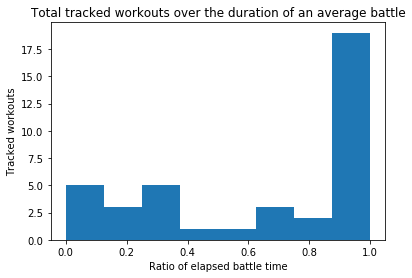

In [89]:
workouts_end_times['workout_created_after'] = (workouts_end_times['workout_created_at'] - workouts_end_times['battle_created_at'])
workouts_end_times['battle_duration'] = workouts_end_times['ended_at'] - workouts_end_times['battle_created_at']
workouts_end_times['workouts_created_ratio'] = workouts_end_times['workout_created_after'] / workouts_end_times['battle_duration'] 

ax = plt.axes()
ax.set_xlabel('Ratio of elapsed battle time')
ax.set_ylabel('Tracked workouts')
ax.set_title("Total tracked workouts over the duration of an average battle")
plt.hist(workouts_end_times.sort_values('workouts_created_ratio')['workouts_created_ratio'], 8)

<ipython-input-86-ae3ea189bde8>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  query = query[with_end_times['groupname'] == row['groupname']]


(array([12.,  4.,  3.,  0.,  1.,  4.,  2.,  1.,  4.,  2.]),
 array([8.73753297e-05, 1.00078638e-01, 2.00069900e-01, 3.00061163e-01,
        4.00052425e-01, 5.00043688e-01, 6.00034950e-01, 7.00026213e-01,
        8.00017475e-01, 9.00008738e-01, 1.00000000e+00]),
 <a list of 10 Patch objects>)

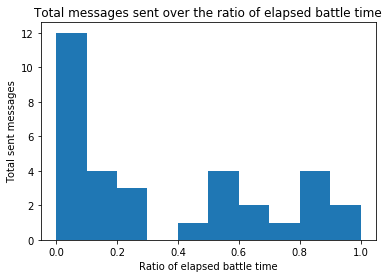

In [86]:
def get_time_ratio(row):
    query = with_end_times[(with_end_times['battle_created_at'] <= row['created_at']) & (row['created_at'] <= with_end_times['ended_at'])]
    query = query[with_end_times['groupname'] == row['groupname']]
    if len(query):
        interval = (row['created_at'] - query.iloc[0]['battle_created_at']).total_seconds() 
        trange = query.iloc[0]['time_range'].total_seconds()
        row['battle_time_ratio'] =(interval / trange)
    return row
with_ratios = chat_df.apply(get_time_ratio, axis = 1)
ax = plt.axes()
ax.set_xlabel('Ratio of elapsed battle time')
ax.set_ylabel('Total sent messages')
ax.set_title("Total messages sent over the ratio of elapsed battle time")
plt.hist(with_ratios['battle_time_ratio'], bins = 10)

<ipython-input-86-ae3ea189bde8>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  query = query[with_end_times['groupname'] == row['groupname']]


(array([113.,  33.,  25.,   9.,  14.,  40.,  12.,  18.,  56.,  90.]),
 array([5.75971019e-05, 1.00039462e-01, 2.00021327e-01, 3.00003192e-01,
        3.99985057e-01, 4.99966922e-01, 5.99948787e-01, 6.99930652e-01,
        7.99912517e-01, 8.99894382e-01, 9.99876248e-01]),
 <a list of 10 Patch objects>)

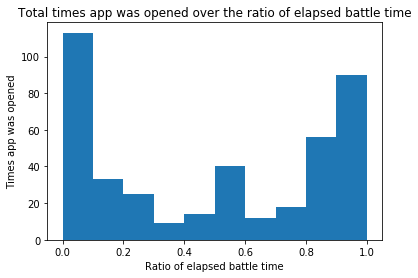

In [92]:
sessions_with_groups = session_analytics_df.merge(user_df.drop(columns=['created_at']), on = "username")
sessions_with_ratios = sessions_with_groups.apply(get_time_ratio, axis = 1)
ax = plt.axes()
ax.set_xlabel('Ratio of elapsed battle time')
ax.set_ylabel('Times app was opened')
ax.set_title("Total times app was opened over the ratio of elapsed battle time")
plt.hist(sessions_with_ratios['battle_time_ratio'], bins = 10)